In [1]:
from __future__ import division, print_function

import time, datetime

import numpy as np

from astropy.modeling import models
from astropy import units as u

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (16, 10)
rcParams['image.interpolation'] = 'none'
rcParams['image.origin'] = 'lower'

## Exponential 

$$\frac{dn}{dm}=A 10^{a (m-\mu)}=A e^{a \ln(10) (m-\mu)}=A e^{\alpha (m-\mu)}$$ wher $\alpha \equiv a \ln(10)$

$$
N= \int^{m_2}_{m_1} A e^{\alpha(m-\mu)} dm = \left. \frac{A}{\alpha} e^{\alpha(m-\mu)} \right\rvert_{m_1}^{m_2}=
\frac{A}{\alpha} e^{-\alpha \mu} \left[ e^{\alpha m_2}-e^{\alpha m_1} \right]
$$

Now we get A for the [$m_1$, $m_2$] range:
$$
N=1 \rightarrow A=\frac{\alpha e^{\alpha \mu}}{e^{\alpha m_2}-e^{\alpha m_1}}
$$

So the final distribution from $m_1$ to $x$ is:
    $$
    N = \frac{e^{\alpha x}-e^{\alpha m_1}}{e^{\alpha m_2}-e^{\alpha m_1}} \rightarrow
    N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} = e^{\alpha x} \rightarrow
    x = \frac{1}{\alpha} \ln{\left[ N (e^{\alpha m_2}-e^{\alpha m_1}) + e^{\alpha m_1} \right]}
    $$

In [3]:
def sample_lf(nsamples, alpha, m1, m2):
    N = np.random.rand(nsamples)
    expa1 = np.exp(alpha*m1)
    expa2 = np.exp(alpha*m2)
    return np.log(N*(expa2-expa1)+expa1)/alpha

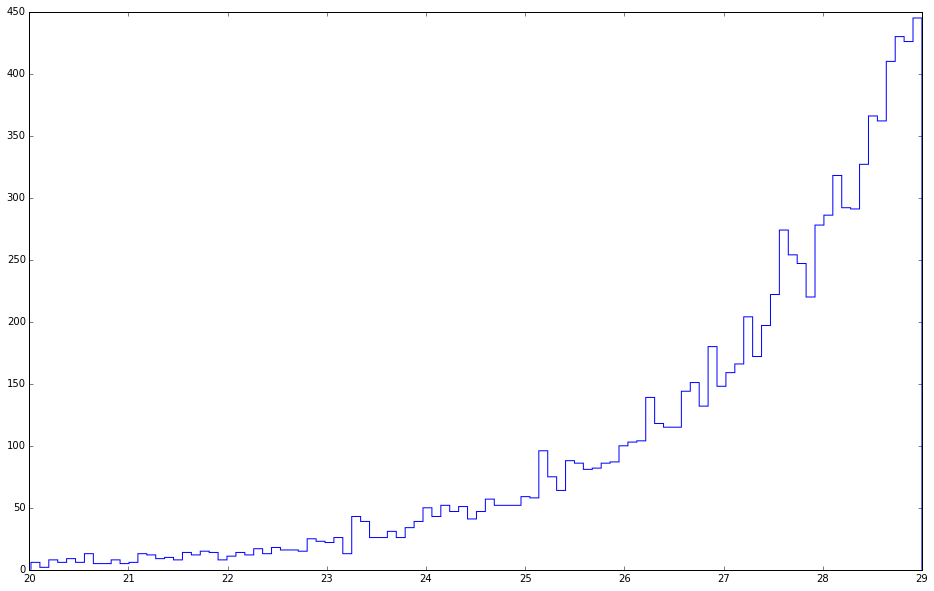

In [4]:
plt.hist(sample_lf(10000, .5, 20, 29), bins=100, histtype='step')
None

# Emceemr tests 

In [5]:
import emceemr
from emceemr import priors
import rgbmcmr

In [6]:
def make_fake_rgb(alpha, beta, mu, brightlimit, faintlimit, nmax, fracrgb):
    """
    
    returns mag0, isrgb
    """    
    #a = alpha + 1
    #b = beta + 1    
    #rgb = np.random.power(a, nmax)*(faintlimit-brightlimit) + brightlimit
    #foreground = np.random.power(b, nmax)*(faintlimit-brightlimit) + brightlimit
    
    rgb = sample_lf(nmax, alpha, brightlimit, faintlimit)
    foreground = sample_lf(nmax, beta, brightlimit, faintlimit)
    
    rgbmsk = rgb>mu
    fgmsk = foreground<mu
    rgb = rgb[rgbmsk]
    foreground = foreground[fgmsk]
    
    starting_fracrgb = len(rgb)/(len(foreground)+len(rgb))
    if starting_fracrgb>fracrgb:
        #too many RGBs
        nrgb = len(foreground)*fracrgb/(1-fracrgb)
        rgb = rgb[:nrgb]
    else:
        #too many fgs
        nfg = len(rgb)*(1-fracrgb)/fracrgb
        foreground = foreground[:nfg]
    
    mags = np.concatenate((rgb, foreground))
    isrgb = np.zeros(len(mags), dtype=bool)
    isrgb[:len(rgb)] = True
    
    unsorti = np.random.permutation(len(mags))
    mags = mags[unsorti]
    isrgb = isrgb[unsorti]
    
    return mags, isrgb

In [7]:
#median absolute deviation from ASTs
madmodel = models.Legendre1D(20, c0=-3954355396.3633738, c1=1353694208.4087687, c2=-124848799.79526304, c3=4897226.378521032, c4=-57041.00249220571, c5=-1549.1100474853888, c6=30.190195895799725, c7=1.1368681316643618, c8=-0.03563103282644921, c9=6.0712498989515646e-05, c10=4.892644246415783e-06, c11=8.248737934921185e-08, c12=-2.3350690477921424e-09, c13=-1.8352224226398223e-11, c14=5.350673251357965e-13, c15=2.4468515243894513e-15, c16=2.6121935517894807e-17, c17=-4.622081469223215e-18, c18=8.23871918441632e-20, c19=-6.005849952016176e-22, c20=1.6539943309668438e-24)

a= 0.690775527898


(397, 67, 0.8556034482758621)

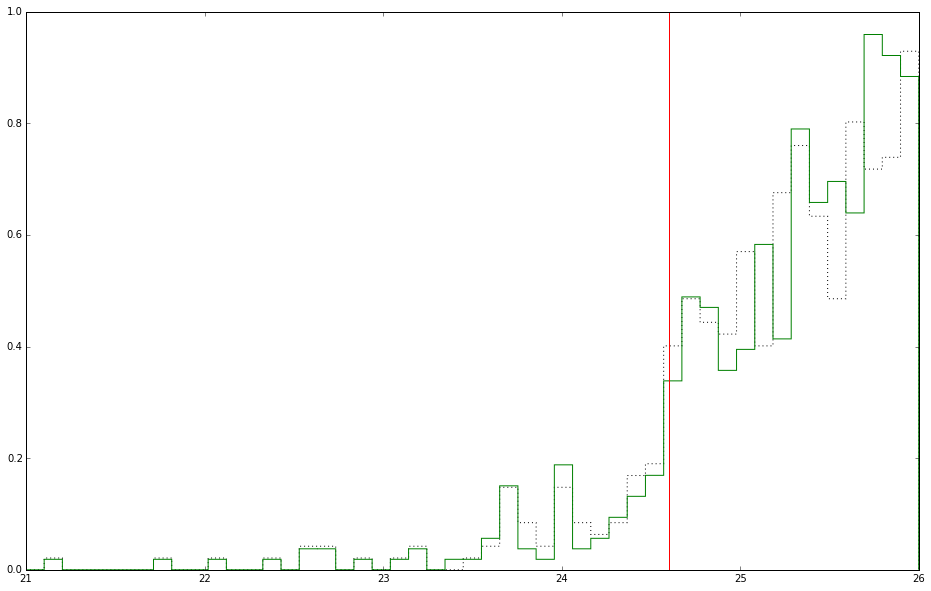

In [8]:
a = np.log(10)*.3
print('a=',a)
b = 1
mu = 24.6

realmags, isrgb = make_fake_rgb(a, b, mu, 21, 29, 5000, .986)

asterrs = madmodel(realmags)*1.483
asterrmags = realmags+np.random.randn(len(realmags))*asterrs


bins = np.linspace(21,26,50)
plt.hist(realmags, bins=bins,histtype='step',normed=True, ls='dotted', color='k')
plt.hist(asterrmags, bins=bins,histtype='step',normed=True, color='g')

inwindow = (bins[0]<realmags)&(realmags<bins[-1])
inrgbwindow = inwindow&(realmags>mu)
inotherwindow = inwindow&(realmags<mu)

plt.axvline(mu,color='r')
np.sum(inrgbwindow), np.sum(inotherwindow), np.sum(inrgbwindow)/np.sum(inwindow)

## Now do test runs of the MCMC

In [9]:
pris = dict(tipmag=priors.UniformPrior(23, 25.5),
            alphargb=priors.UniformPrior(0, 5), 
            alphaother=priors.UniformPrior(0, 5),
            fracother=priors.UniformPrior(0,0.5))

### "Intrinsic" mags 

In [10]:
astmod = rgbmcmr.RGBModel(realmags[inwindow], None, priors=pris)

In [11]:
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-01 20:28:44.503281
Took 0.10744929711 min


Acors:
tipmag: 59.8956231136
alphargb: 59.6993554547
alphaother: 57.7074965338
fracother: 49.7049729085
Acceptance Fractions:
[ 0.439 ,  0.3972,  0.429 ,  0.4418,  0.424 ,  0.4248,  0.4408,  0.4096,
  0.4282,  0.4338,  0.418 ,  0.43  ,  0.425 ,  0.4432,  0.4204,  0.4262]


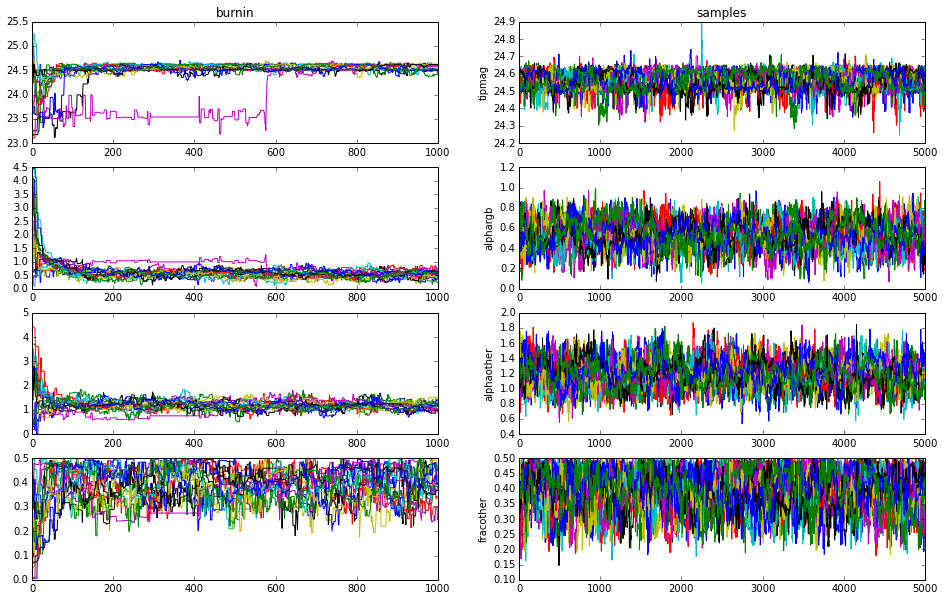

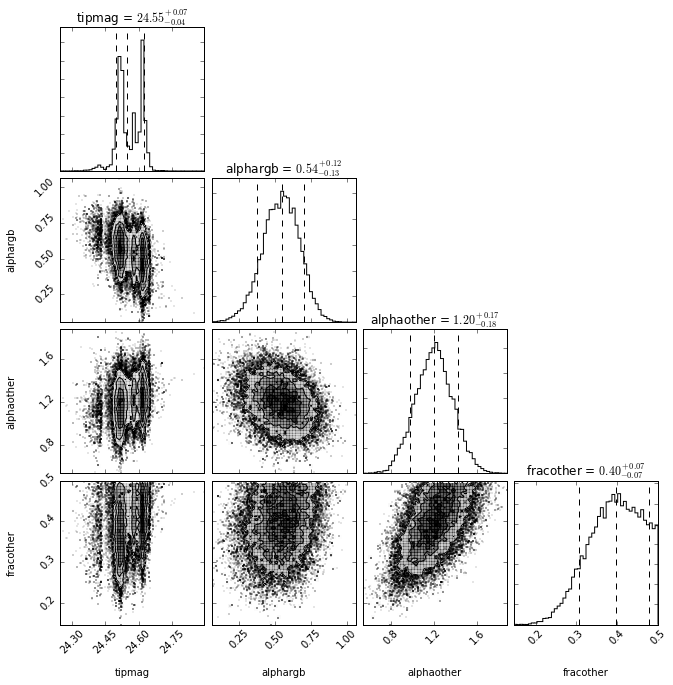

In [12]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

### With AST 

In [13]:
astmod = rgbmcmr.RGBModel(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483, priors=pris)

In [14]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
ntarg = 6000
print('20 samples took', dt, 'which scales up to',ntarg,'samples in',(dt*ntarg/20).to(u.minute))

20 samples took 0.121023893356 s which scales up to 6000 samples in 0.605119466782 min


In [15]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

Starting at 2015-12-01 20:28:54.837113
Took 0.553984634082 min


Acors:
tipmag: 48.2946030649
alphargb: 52.3203822635
alphaother: 49.8789890332
fracother: 48.7328943843
Acceptance Fractions:
[ 0.554 ,  0.5342,  0.5512,  0.5292,  0.5448,  0.5306,  0.539 ,  0.5414,
  0.5444,  0.5484,  0.5354,  0.5502,  0.5516,  0.5554,  0.554 ,  0.5634]


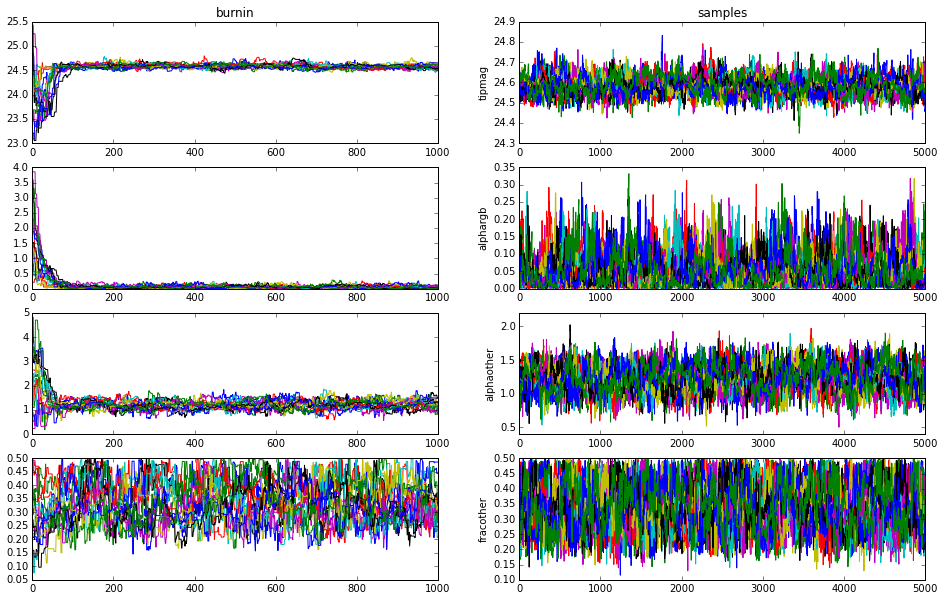

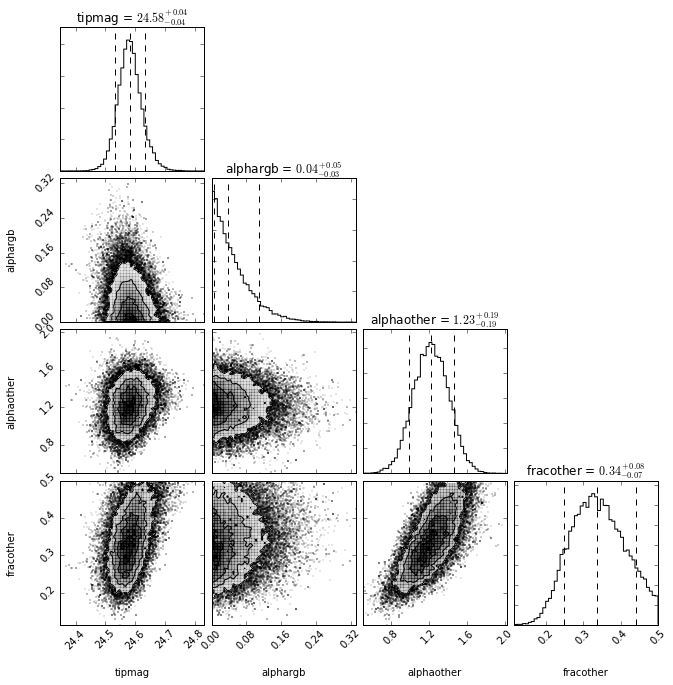

In [16]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

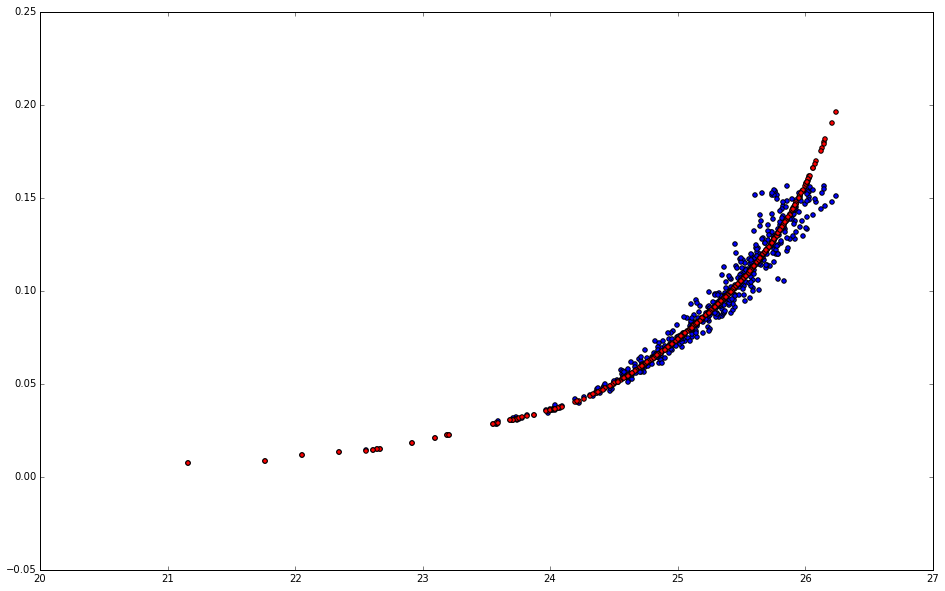

In [17]:
plt.scatter(asterrmags[inwindow], asterrs[inwindow])
plt.scatter(asterrmags[inwindow], madmodel(asterrmags[inwindow])*1.483,c='r')

# Test with the completeness function model 

In [18]:
reload(rgbmcmr)

astmod = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          uncfunc=lambda x:madmodel(x)*1.483,
                          priors=pris)

In [19]:
#experimental timing run
st = time.time()
sampler = astmod.initialize_and_sample(15, burnin=5)
et = time.time()
dt = (et - st)*u.second
    
ntarg = 6000
print('20 samples took', dt, 'which scales up to',ntarg,'samples in',(dt*ntarg/20).to(u.minute))

20 samples took 1.11796689034 s which scales up to 6000 samples in 5.58983445168 min


In [ ]:
#now the real deal
print('Starting at', datetime.datetime.now())
st = time.time()
sampler = astmod.initialize_and_sample(5000, burnin=1000)
et = time.time()
dt = (et - st)*u.second
print('Took',dt.to(u.minute))

In [ ]:
plt.figure()
emceemr.plot_chains(astmod, sampler,incl_burnin=True)
plt.figure()
emceemr.triangle_plot(astmod, sampler, quantiles=[.1, .5, .9], show_titles=True, verbose=False)

print(emceemr.sampler_info_string(astmod, sampler))

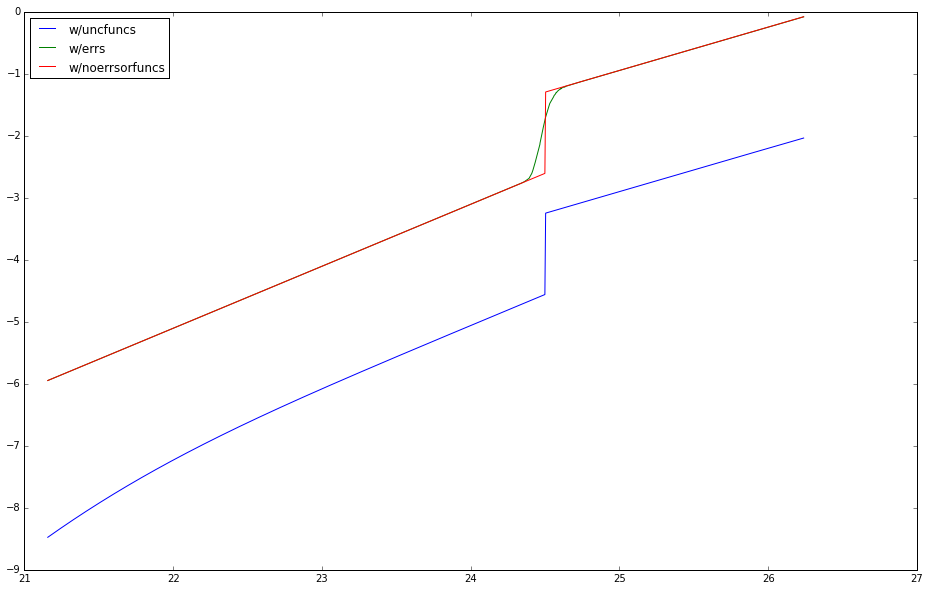

In [35]:
reload(rgbmcmr)

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          #uncfunc=lambda x:madmodel(x)*1.483*1,
                           uncfunc=lambda x:1,
                          priors=pris)
astmod1.plot_lnprob(24.5,0.7,1,.27, 1000)

astmod2 = rgbmcmr.RGBModel(asterrmags[inwindow], asterrs[inwindow],
                          priors=pris)
astmod2.plot_lnprob(24.5,0.7,1,.27, astmod2.magdata)

astmod3 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          priors=pris)
astmod3.plot_lnprob(24.5,0.7,1,.27, 1000)

plt.legend(['w/uncfuncs', 'w/errs','w/noerrsorfuncs'],loc=0)
None

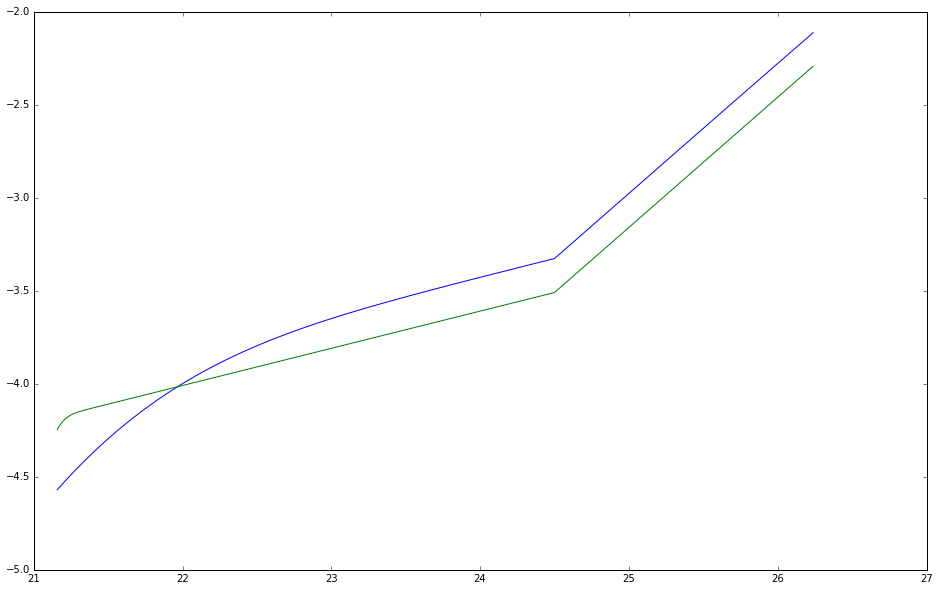

In [22]:

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          #uncfunc=lambda x:madmodel(x)*1.483*1,
                           uncfunc=lambda x:1,
                          priors=pris)
astmod1.plot_lnprob(24.5,0.7,0.2,1, 1000)

astmod1 = rgbmcmr.RGBModel(asterrmags[inwindow], 
                          funcmags=np.linspace(21, 29,100), 
                          #uncfunc=lambda x:madmodel(x)*1.483*1,
                           uncfunc=lambda x:0.1,
                          priors=pris)
astmod1.plot_lnprob(24.5,0.7,0.2,1, 1000)
None

# Numerical derivative tests 

In [23]:
from scipy.stats import norm
from scipy.special import erf

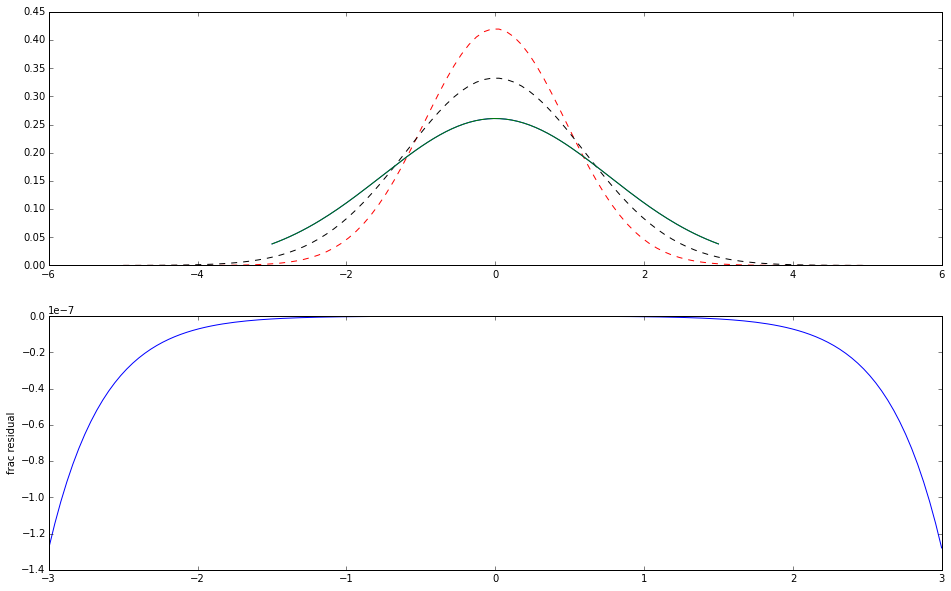

In [38]:
#two gaussians convolved
s1 = 0.95
s2 = 1.2
s12 = np.hypot(s1, s2)

norm1 = norm(scale=s1)
norm2 = norm(scale=s2)
norm12 = norm(scale=s12)

x = np.linspace(-5,5, 100) # integrate over this
y = np.linspace(-3,3, 150) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)
integ = np.trapz(norm1.pdf(xr)*norm2.pdf(xr-yr), x, axis=0)

plt.subplot(2,1,1)
plt.plot(x, norm1.pdf(x), '--r')
plt.plot(x, norm2.pdf(x), '--k')
plt.plot(y, integ, c='b')
plt.plot(y, norm12.pdf(y), c='g')

plt.subplot(2,1,2)
true = norm12.pdf(y)
plt.plot(y, (integ-true)/true)
plt.ylabel('frac residual')
None

In [46]:
(theta*theta2).shape

(100, 150)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


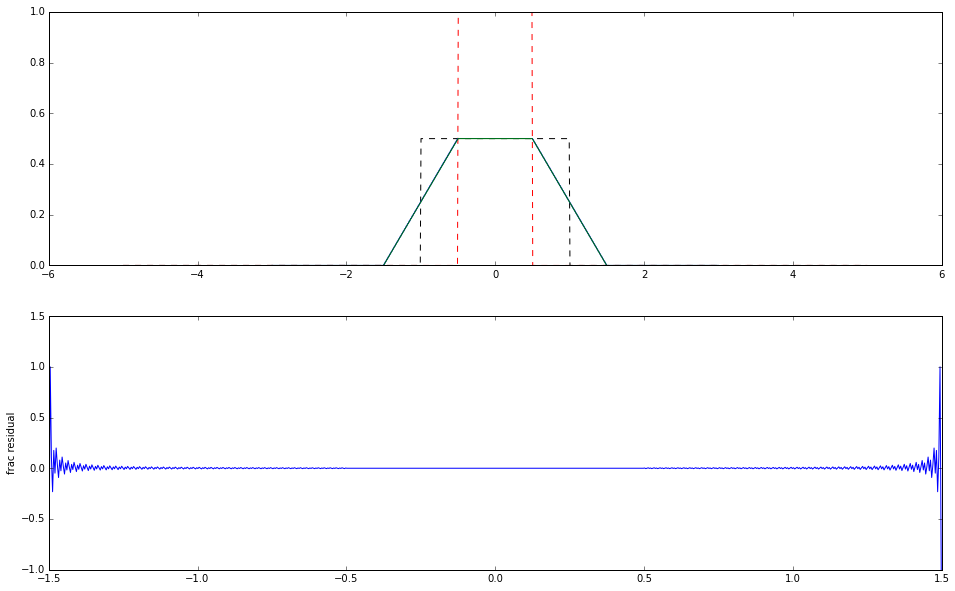

In [102]:
#square w/square
w1 = 1.
w2 = 2.0

def make_theta(x, w, cen=0):
    theta = np.ones_like(x)/w
    theta[x>(cen+w/2.)] = 0
    theta[x<(cen-w/2.)] = 0
    return theta

x = np.linspace(-5,5, 1000) # integrate over this
y = np.linspace(-3,3, 1500) # the independent variable
xr = x.reshape(x.size, 1)
yr = y.reshape(1, y.size)

theta = make_theta(xr, w1)
theta2 = make_theta(xr, w2)
theta2_integ = make_theta(xr-yr, w2)

integ = np.trapz(theta*theta2_integ, xr, axis=0)

#theta with triangles
outer_edge = (w1+w2)/2
inner_edge = np.ptp([w1,w2])/2
true = make_theta(y, inner_edge*2)*inner_edge
slope = 0.5/(inner_edge-outer_edge)
true[y>inner_edge] = (y[y>inner_edge]-outer_edge)*slope
true[y>outer_edge] = 0

true[y<-inner_edge] = (y[y<-inner_edge]+outer_edge)*-slope
true[y<-outer_edge] = 0

plt.subplot(2,1,1)
plt.plot(x, theta.ravel(), '--r')
plt.plot(x, theta2.ravel(), '--k')
plt.plot(y, integ, c='b')
plt.plot(y, true, c='g')

plt.subplot(2,1,2)
plt.plot(y, (integ-true)/true)
plt.ylabel('frac residual')